In [1]:
import pandas as pd
import argparse
import logging
from pathlib import Path
from utils.data_loading import SGCCDataset
import torch
from unet import UNet_1D, UNet_1D_N, UNet_1D_L, UNet_1D_NN
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def predict_data(net,
                data,
                device,
                out_threshold=0.5):
    net.eval()
    data = data.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        print(data.shape)
        output = net(data).cpu()
        # print(output.size())
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold
        # print(mask.size())
    return mask[0].long().squeeze().numpy()

In [ ]:
def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images')
    parser.add_argument('--data_name', type=str, default='SGCC', help='Name of the dataset')
    parser.add_argument('--attack_id', type=int, default=1, help='Attack ID')
    parser.add_argument('--val_percent', type=float, default=0.1, help='Validation percentage')
    parser.add_argument('--model', '-m', default='best_checkpoint.pth', metavar='FILE', help="Specify the file in which the model is stored")
    return parser.parse_known_args()

In [4]:
args, _ = get_args()
data_name = args.data_name
attack_id = args.attack_id
val_percent = args.val_percent
model = args.model
dir_checkpoint = Path(f'./checkpoints_pseudo_{data_name}/')

In [5]:
zx3_normalized = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/zx{attack_id}_normalized.csv') 
normal3_normalized = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized.csv')
# Rename the columns of df2 to match df1
normal3_normalized.columns = zx3_normalized.columns

zy3 = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/zy{attack_id}.csv') 
normal3_normalized_label = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized_label.csv')
normal3_normalized_label.columns = zy3.columns

combined_dfx = pd.concat([zx3_normalized, normal3_normalized], ignore_index=True)#
combined_dfy = pd.concat([zy3, normal3_normalized_label], ignore_index=True)#


combined_dfx.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfx.csv', index=False)
combined_dfy.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy.csv', index=False)

normal3_normalized_pseudolabel2 = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized_pseudolabel.csv')
normal3_normalized_pseudolabel2.columns = zy3.columns
combined_dfy_pseudo2 = pd.concat([zy3, normal3_normalized_pseudolabel2], ignore_index=True)#
combined_dfy_pseudo2.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy_pseudo.csv', index=False)

In [6]:
combined_dfy_pseudo2.shape

(2788, 304)

In [7]:
##### testing 用的predict_t.py
# data_name = ''
##### 改变的地方是：
dir_data = Path(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfx.csv')
# dir_mask = Path('./combined_dfy.csv')
dir_mask = Path(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy_pseudo.csv')
dataset = SGCCDataset(dir_data, dir_mask)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data = dataset.data_tensor
mask = dataset.mask_tensor

data_train = torch.tensor(np.array([train_set[i]['data'] for i in range(len(train_set))]).squeeze())
mask_train = torch.tensor(np.array([train_set[i]['mask'] for i in range(len(train_set))]).squeeze())

data_val = torch.tensor(np.array([val_set[i]['data'] for i in range(len(val_set))]).squeeze())
mask_val = torch.tensor(np.array([val_set[i]['mask'] for i in range(len(val_set))]).squeeze())

net = UNet_1D(n_channels=1, n_classes=2, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)
state_dict = torch.load(f'./checkpoints_pseudo_{data_name}/{model}', map_location=device)
# state_dict = torch.load(f'./checkpoints_pseudo_{data_name}/checkpoint_epoch20.pth', map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

/tmp/ipykernel_3122813/928295334.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./checkpoints_pseudo_{data_name}/{model}', map_location=devic

<All keys matched successfully>

In [8]:
data_val.shape, mask_val.shape

(torch.Size([278, 304]), torch.Size([278, 304]))

In [9]:
val_set[0].keys()

dict_keys(['data', 'mask'])

In [10]:
result = []
pred_ts = []
for i in range(len(data_val)):
    item = data_val[i, :].unsqueeze(0).unsqueeze(0)
    print(item.shape)
    
    mask = predict_data(net=net,
                        data=item,
                        out_threshold=0.5,
                        device=device)

    result.append(mask)

torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1

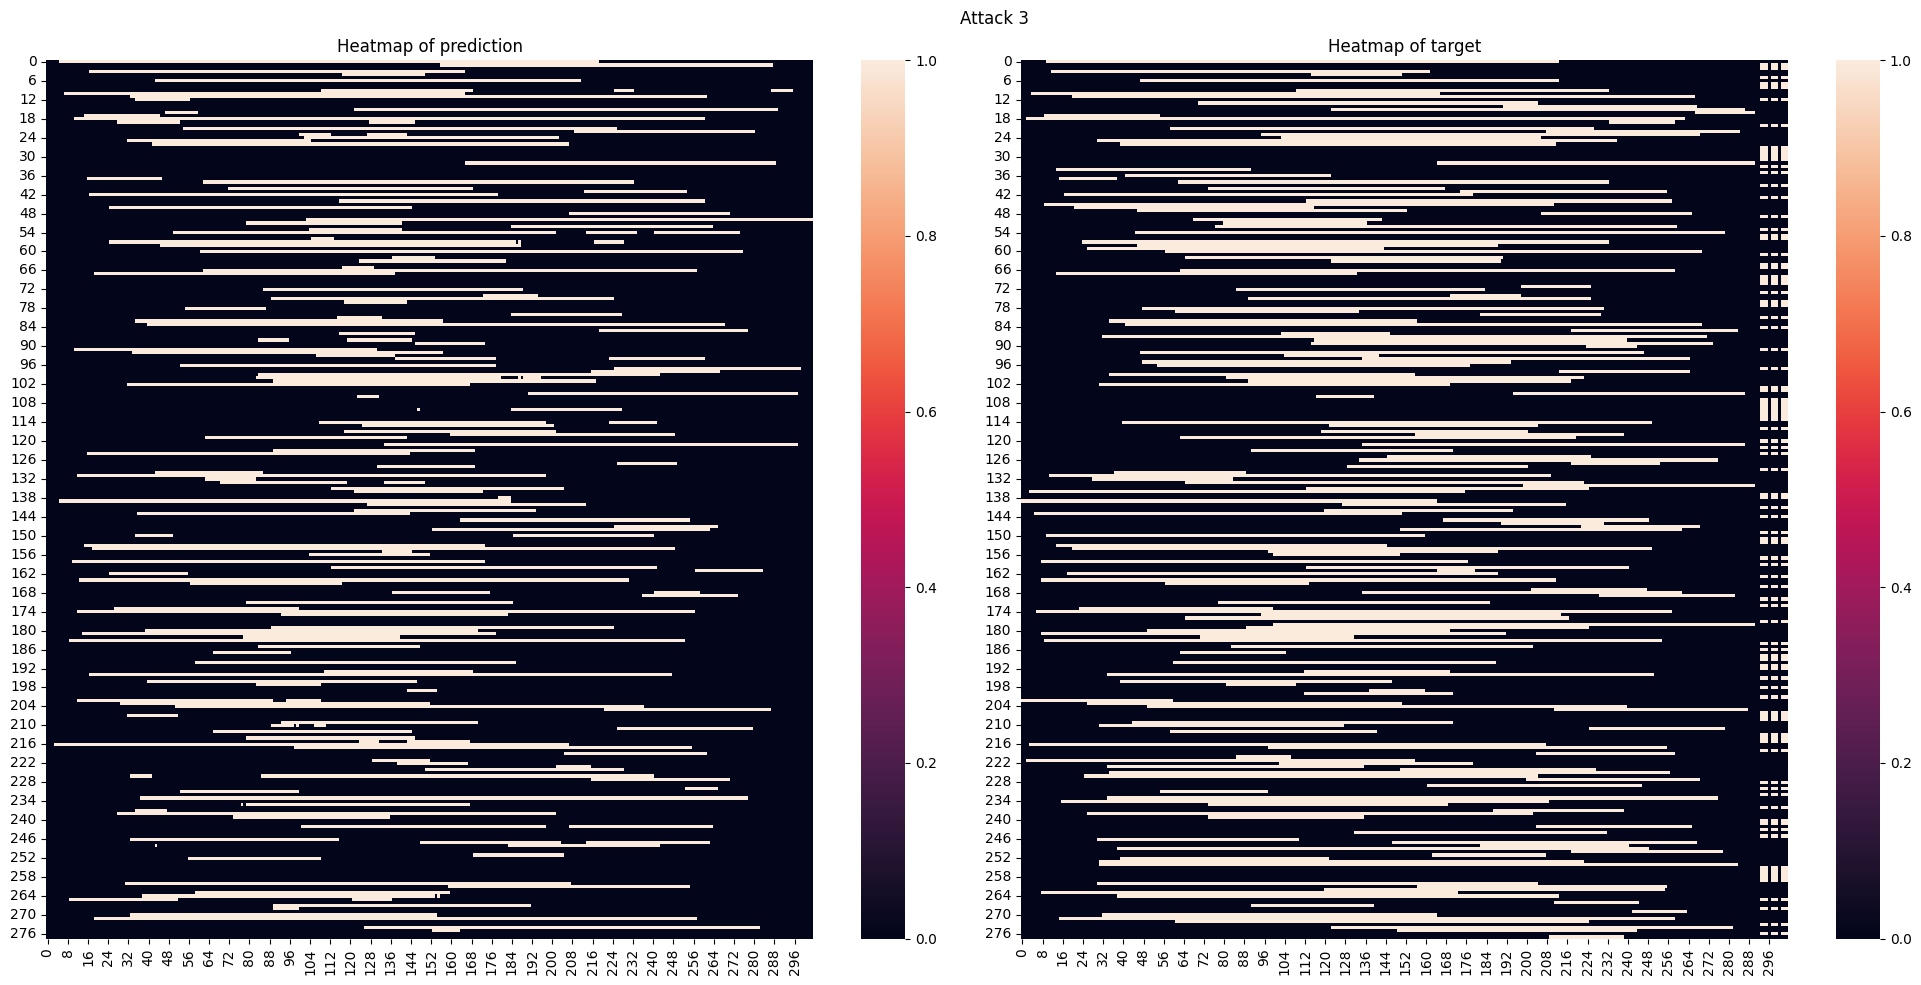

In [11]:
result_df = pd.DataFrame(result)
# result_df.to_csv('result.csv', index=False)
zy = pd.DataFrame(np.array(mask_val).astype(int))
# zy = pd.read_csv('./combined_dfy.csv')
# zy = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy_pseudo.csv')
# zy = pd.read_csv('.\Attack3_normalized_label.csv')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'Attack 3')   

# Plot the first heatmap
sns.heatmap(result_df, ax=ax1)
ax1.set_title('Heatmap of prediction')

# Plot the second heatmap
sns.heatmap(zy, ax=ax2)
ax2.set_title('Heatmap of target')

# Display the plot
plt.tight_layout()
# plt.savefig(f'result{data_name}.png')
plt.show()

In [12]:
result_df.shape, zy.shape

((278, 304), (278, 304))

In [13]:
# 检测窃电，如果连续有7个1，就标记为窃电
def mark_continuous_ones(df, threshold=7):
    def has_continuous_ones(row):
        count = 0
        for value in row:
            if value == 1:
                count += 1
                if count >= threshold:
                    return True
            else:
                count = 0
        return False

    return df.apply(has_continuous_ones, axis=1)

In [14]:
# Example usage:
result_marked = mark_continuous_ones(result_df)
zy_marked = mark_continuous_ones(zy, threshold=7)

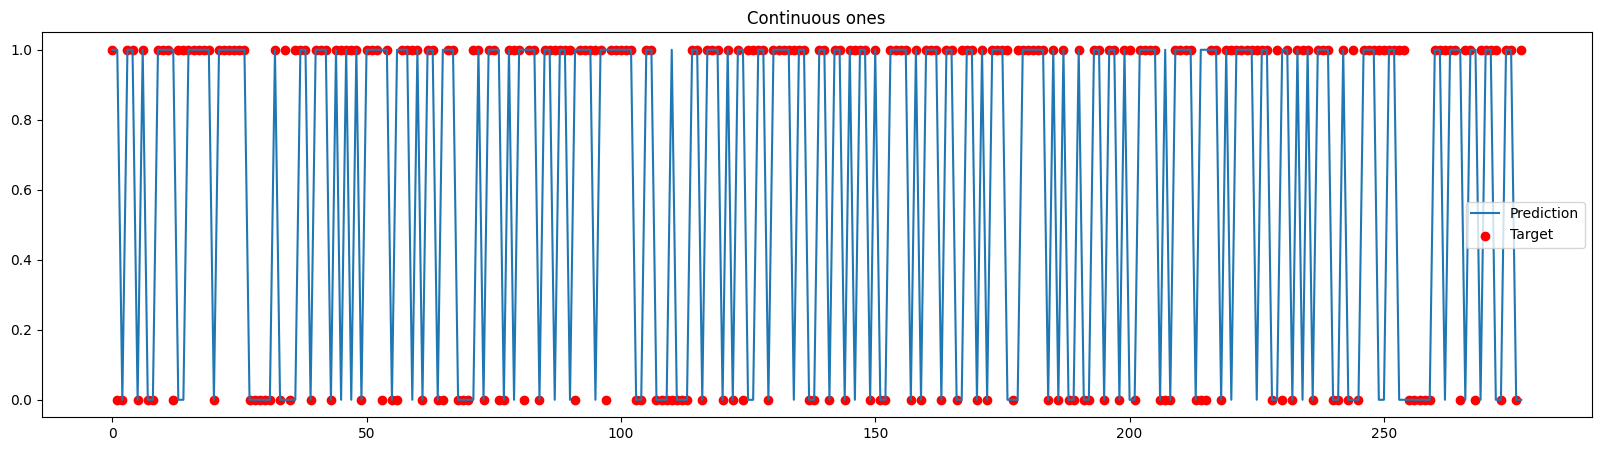

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(result_marked, label='Prediction')
plt.scatter(np.arange(len(zy_marked)), zy_marked, label='Target', color='red')
plt.title('Continuous ones')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(zy_marked, result_marked)

# Calculate F1 score
f1 = f1_score(zy_marked, result_marked)

# Calculate recall
recall = recall_score(zy_marked, result_marked)

auc = roc_auc_score(zy_marked, result_marked)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Accuracy: 0.8165467625899281
F1 Score: 0.8547008547008547
Recall: 0.8152173913043478
AUC: 0.8171831637372803
